Классическая архитектура Трансформера состоит из энкодера и декодера.

На основе энкодера была создана модель BERT и подобные ей (RoBERTa, ALBERT). Они используются для получения контекстных векторных представлений слов и предложений. Затем модели дообучаются для конкретной задачи, что требует наличия размеченного набора данных.

На основе энкодера была создана модель GPT — Generative Pretrained Transformer. Модель GPT была обучена на задаче языкового моделирования, то есть для предсказания (определения вероятности) следующего слова в тексте.

## Четыре поколения GPT


- GPT-1: [Improving Language Understanding by Generative Pre-Training](https://cdn.openai.com/research-covers/language-unsupervised/language_understanding_paper.pdf)

Первая версия этой модели состояла из 12 слоёв и была обучена на 7000 книг. Как языковая модель она работала не очень хорошо, но при дообучении на отдельных задачах показывала высокое качество и SOTA результаты. Максимальный размер контекста у GPT-1 — 512 токенов.

- GPT-2: [Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)

SOTA результаты GPT-1 держались недолго, так как появился BERT. Новая GPT-2 содержала 48 слоёв и 1.5 миллиарда параметров. Размер обучающих данных значительно увеличился: к книгам добавили 8 миллионов сайтов, суммарно получилось 40 Гб текста. GPT-2 научилась писать длинные связные тексты. Максимальный размер контекста у GPT-2 — 1024 токенов.

- GPT-3: [Language Models are Few-Shot Learners](https://arxiv.org/pdf/2005.14165.pdf)

GPT-3 имет уже 96 слоев и 175 миллиардов параметров. Она обучена на ещё большем количестве данных — 570 Гб текста. Модель научилась писать рабочий программный код и решать много других NLP-задач без дообучения. Максимальный размер контекста у GPT-3 — 2048 токенов.

- GPT-4: статья отсутствует.

Нет информации про обучение модели. Работает с контекстом до 8192 токенов. Есть версия, поддерживающая 32 768 токенов (50 страниц). Помимо текстов, умеет работать с изображениями, является мультимодальной.

## Токенизация и генерация текста

Посмотрим на работу модели ruGPT-3 для русского языка. Она доступна в трех вариантах:
- small: [ai-forever/rugpt3small_based_on_gpt2](https://huggingface.co/ai-forever/rugpt3small_based_on_gpt2)
- medium: [ai-forever/rugpt3medium_based_on_gpt2](https://huggingface.co/ai-forever/rugpt3medium_based_on_gpt2)
- large: [ai-forever/rugpt3large_based_on_gpt2](https://huggingface.co/ai-forever/rugpt3large_based_on_gpt2)

Для загрузки токенизатора потребуется класс AutoTokenizer, для загрузки модели — класс AutoModelForCausalLM.

In [1]:
!pip install transformers -q

from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
DEVICE = torch.device("cuda:0")

MODEL_NAME = "ai-forever/rugpt3large_based_on_gpt2"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME).to(DEVICE)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.71M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/622 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/3.14G [00:00<?, ?B/s]

Рассмотрим пример токенизации. Как и BERT-like модели, GPT использует токенизацию на подслова.

In [2]:
text = "Токенизируй меня" # изначальный текст
tokens = tokenizer.encode(text, add_special_tokens=False) # процесс токенизации с помощью токенизатора ruGPT-3
decoded_tokens = [tokenizer.decode([token]) for token in tokens] # обратная поэлементая токенизация

print("text:", text)
print("tokens: ", tokens)
print("decoded tokens: ", decoded_tokens)

text: Токенизируй меня
tokens:  [789, 368, 337, 848, 28306, 703]
decoded tokens:  ['Т', 'ок', 'ени', 'зи', 'руй', ' меня']


Языковая модель выдаёт распределение вероятностей следующего токена, эту информацию можно по-разному использовать для генерации текста.

Для наглядности применим все основные методы для продолжения следующего: 'Определение: "Языковая модель" - это'

In [6]:
# Заранее токенизируем текст
text = 'Определение: "Языковая модель" — это'
input_ids = tokenizer.encode(text, return_tensors="pt").to(DEVICE)

### Жадный поиск

Самый простой способ — жадный поиск (greedy search): каждый раз выбирается токен, у которого максимальная вероятность. Это не самый лучший метод, так как в таком случае генерация часто выдаёт повторяющиеся фрагменты.

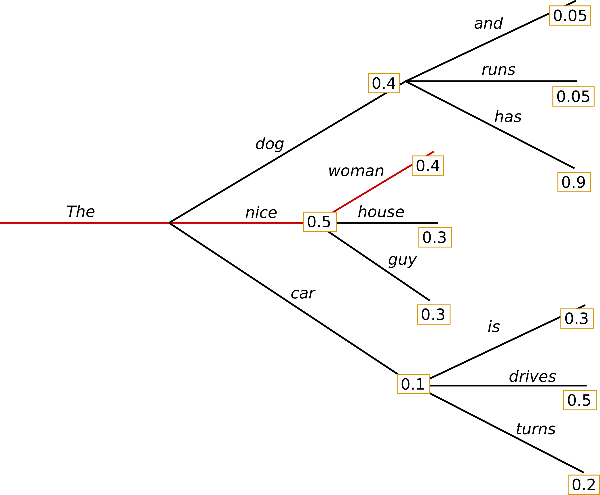

In [8]:
# Пример генерации с помощью жадного поиска
out = model.generate(input_ids, do_sample=False, max_length=30)

# Декодирование токенов
generated_text = list(map(tokenizer.decode, out))[0]
print(generated_text)

Определение: "Языковая модель" — это модель, которая описывает, как люди воспринимают и интерпретируют язык. Языковая модель — это


### Лучевой поиск


Чуть более сложный и качественный способ — это лучевой поиск (beam search). На каждом шаге выбирается не только один самый вероятный токен, а сразу несколько (за их количество отвечает параметр `num_beams`). Дальше продолжается поиск для каждого из выбранных токенов. Пути генерации разветвляются, что дает несколько вариантов сгенерированного текста. Такая генерация обладает хорошей когерентностью (связностью), но обычно у них не хватает "человечности", они кажутся сухими и скучными. Также это не полностью решает проблему повторяющихся фрагментов генерации.

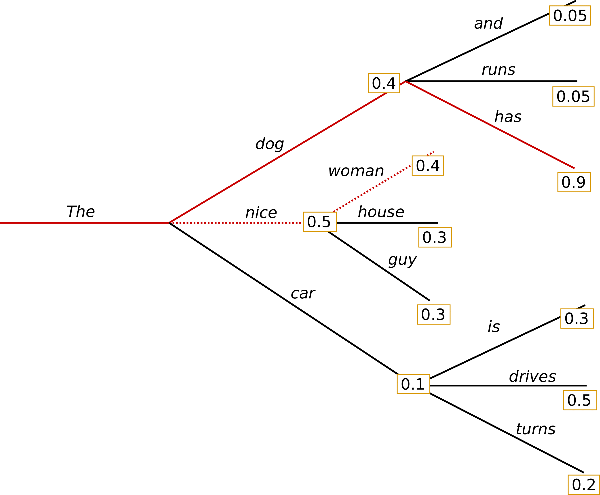

In [9]:
# Пример генерации с помощью лучевого поиска
out = model.generate(input_ids, do_sample=False, num_beams=5, max_length=40)

# Декодирование токенов
generated_text = list(map(tokenizer.decode, out))[0]
print(generated_text)

Определение: "Языковая модель" — это совокупность языковых средств, используемых в речи для выражения мыслей, чувств, убеждений и т. д. Языковая модель — это совокупность языковых


### Сэмплирование с температурой

Чтобы добавить тексту непредсказуемости, можно использовать вероятностное сэмплирование с температурой. При такой генерации следующий токен выбирается "случайно" с учётом распределения вероятностей. Параметр температуры позволяет контролировать степень рандомности. При нулевой температуре этот метод совпадает с жадным поиском, а при очень большой температуре токены будут выбираться совсем наугад. Обычно хорошо работает температура в диапазоне `0.8 - 2.0`. У этого метода есть и минусы, ведь случайная природа генерации будет изредка приводить к совсем некорректным результатам.

In [10]:
# Пример вероятностного сэмплирования с температурой
out = model.generate(input_ids, do_sample=True, temperature=1.3, max_length=30)

# Декодирование токенов
generated_text = list(map(tokenizer.decode, out))[0]
print(generated_text)

Определение: "Языковая модель" — это такая модель, когда люди разделены лингвистическими, культурными барьерами, у многих


### Сэмплирование top-k и top-p

Для запрета генерации маловероятных токенов вводят `top-k` или `top-p` ограничения. В этом случае генерация тоже происходит случайным образом, но заранее отсекаются все маловероятные токены. В случае `top-k` зануляются все вероятности кроме `k` самых вероятных . В случае `top-p` остается минимальный набор токенов, чтобы сумма их вероятностей была не больше `p`. Ограничение `top-p` называют ядерным сэмплированием (nucleus sampling).

In [11]:
# Пример вероятностного сэмплирования с ограничением
out = model.generate(input_ids,
                     do_sample=True,
                     temperature=1.3,
                     top_k=20,
                     top_p=0.8,
                     max_length=30,
                    )
# Декодирование токенов
generated_text = list(map(tokenizer.decode, out))[0]
print(generated_text)

Определение: "Языковая модель" — это метод описания, классификации и анализа языковой модели языка, основанный на сопоставлении языковых единиц в


## Затравочное программирование

В отличие от BERT-like моделей, для GPT этап дообучения не обязателен. Для того чтобы дописывать текст, модель должна очень хорошо понимать его смысл и иметь знания о реальном мире. Внутренние знания модели можно попытаться использовать, модифицируя левый контекст текста. Поскольку GPT способна генерировать текст, мы можем сформулировать любую NLP-задачу как задачу генерации (продолжения) текста. Это позволяет решать множество задач с минимальным обучением или без него.

Подбор модификаций текста называется "затравочное программирование" (prompt engineering). Суть затравочного программирования в том, чтобы подобрать такие заготовленные примеры и начала для генерации, чтобы дальше модель выдавала ровно то, что надо. Подбирая "затравки" и гиперпараметры генератора (температура, `top-k`, `top-p`), можно добиться хороших ответов только за счет предварительного обучения модели.

Существует два подхода для затравочного программирования:
- zero-shot: сформулировать задачу и передать текст на генерацию;
- few-shot: сформулировать задачу, подать в модель несколько примеров и затем передать текст на генерацию.

In [12]:
# zero-shot learning
text = "С английского на русский 'cat' переводится как '"
input_ids = tokenizer.encode(text, return_tensors="pt").to(DEVICE)
out = model.generate(input_ids, do_sample=False,max_length=15)

generated_text = list(map(tokenizer.decode, out))[0]
print(generated_text)

С английского на русский 'cat' переводится как 'кошка'.



In [13]:
# few-shot learning
text = "С английского на русский 'cat' переводится как 'кошка', 'dog' переводится как 'собака', а 'bird' переводится как '"
input_ids = tokenizer.encode(text, return_tensors="pt").to(DEVICE)
out = model.generate(input_ids, do_sample=False,max_length=35)

generated_text = list(map(tokenizer.decode, out))[0]
print(generated_text)

С английского на русский 'cat' переводится как 'кошка', 'dog' переводится как 'собака', а 'bird' переводится как 'птица'.


### Рекомендательная система

Сделаем рекомендательную систему без обучения: будем подавать информацию о предпочтениях пользователя в виде текста и смотреть, как модель продолжит его. Для генерации специально будем подавать текст с незакрытой кавычкой, чтобы вынудить модель генерировать имена собственные.

In [21]:
# Рекомендация фильмов
text = "Я люблю советские комедии: “Приключения Шурика”, “"
input_ids = tokenizer.encode(text, return_tensors="pt").to(DEVICE)
out = model.generate(input_ids,
                     do_sample=True,
                     temperature=1.4,
                     top_k=20,
                     top_p=0.8,
                     max_length=30,
                    )

generated_text = list(map(tokenizer.decode, out))[0]
print(generated_text)

Я люблю советские комедии: “Приключения Шурика”, “Служебный роман”, “Двенадцать стульев”, а вот современные мне не


In [32]:
# Рекомендация музыки
text = "Тем людям, кому нравится “Алиса”, также понравятся группы “"
input_ids = tokenizer.encode(text, return_tensors="pt").to(DEVICE)
out = model.generate(input_ids,
                     do_sample=True,
                     temperature=1.1,
                     top_k=10,
                     top_p=0.7,
                     max_length=30,
                    )

generated_text = list(map(tokenizer.decode, out))[0]
print(generated_text)

Тем людям, кому нравится “Алиса”, также понравятся группы “Блюз”, “Ария” и “Пикник”.<s>



### Анализ тональности

Рассмотрим бинарную классификацию по тональности без дообучения.

Для определения тональности будем использовать меру перплексии. В теории информации, перплексия – мера того, насколько хорошо распределение вероятностей предсказывает выборку. Говоря простым языком, перплексия – мера "удивлённости" модели.

На вход модели мы подаём затравку в формате <метка тональности> + <отзыв>. Далее мы считаем перплексию каждого из них. Выбираем наименьшую перплексию из двух и присваиваем метку отзыву.

In [33]:
import math

def calculate_perplexity(sentence, model, tokenizer):
    # Добавляем к предложению метки тональности
    sentence_positive = 'доволен:'+sentence
    sentence_negative = 'недоволен:'+sentence
    list_sent = [sentence_positive, sentence_negative]
    ppl_values = []

    for sentence in list_sent:
      # Токенизируем предложения
      encodings = tokenizer(sentence, return_tensors='pt')
      input_ids = encodings.input_ids.to(DEVICE)
      # Применяем модель
      with torch.no_grad():
          outputs = model(input_ids=input_ids, labels=input_ids)
      loss = outputs.loss
      # Подсчитываем перплексию
      ppl = math.exp(loss.item() * input_ids.size(1))
      ppl_values.append(ppl)

    # Выбираем предложение с меньшим значением перплексии
    if ppl_values[0] > ppl_values[1]:
      return 'отрицательный'
    else:
      return 'положительный'

In [34]:
negative = 'я чуть не заснул во время фильма'
print(f'Отзыв "{negative}": {calculate_perplexity(negative, model, tokenizer)}')
positive = 'сюжет невероятно захватывающий'
print(f'Отзыв "{positive}": {calculate_perplexity(positive, model, tokenizer)}')

Отзыв "я чуть не заснул во время фильма": отрицательный
Отзыв "сюжет невероятно захватывающий": положительный


## Одна модель для всех задач

Один из последних быстро развивающихся трендов в NLP — решать множество задач одной общей моделью.

- Предобучение трансформерных моделей на большом объеме неразмеченных данных закладывает широкое понимание языка
- Дообучение под конкретную задачу требует наличия размеченных корпусов гораздо меньшего размера
- При правильных затравках (инструкциях) предобученные модели могут решать задачи, которые они никогда не видели
- Все возможные NLP задачи можно свести к генерации текста: генерация перевода для машинного перевода, генерация метки класса для классификации, генерация исправленной последовательности для исправления опечаток, генерация именованых сущностей для извлечения именованных сущностей. Главное — правильно сформулировать затравку или инструкцию.


### Дообучение на инструкциях

Идея: сформулировать много задач как инструкции и дообучить на всех одновременно. Она была реализована для модели FLAN и описана в статье ["Finetuned Language Models Are Zero-Shot Learners"](https://arxiv.org/abs/2109.01652). 62 набора данных для решения различных NLP задач были переделаны в один большой датасет разнообразных инструкций, чтобы обучить модель решать сразу всё.
Примеры инструкций:
- Please translate this sentence to French: 'The dog
runs.'
- What is the sentiment of this text? Options: Negative, Positive, Neutral.

Было замечено, что модель обладает обобщающей способностью и выполняет инструкции, которых она никогда не видела. Так как модель предобучена на большом количестве текстов, она уже хорошо понимает язык и экстраполирует инструкции из обучающей выборки, используя свое понимание языка.

In [35]:
MODEL_NAME = 'google/flan-t5-small'

from transformers import AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, model_max_length=512)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [36]:
def predict_for_instruction(instruction, text, model):

    inputs = tokenizer([instruction.format(text)],
                        return_tensors="pt", padding=True)
    output_sequences = model.generate(
        num_beams=5,
        max_length=100,
        no_repeat_ngram_size=3,
        early_stopping=True,
        num_return_sequences= 1,
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        do_sample=False,
    )
    summaries = tokenizer.batch_decode(output_sequences, skip_special_tokens=True)
    return summaries[0]

In [37]:
text="Lomonosov Moscow State University is a public research university in Moscow, Russia, and the most prestigious university in the country. \
The university includes 15 research institutes, 43 faculties, more than 300 departments, and six branches (including five foreign ones in the Commonwealth of Independent States countries). \
Alumni of the university include past leaders of the Soviet Union and other governments. As of 2019, 13 Nobel laureates, six Fields Medal winners, and one Turing Award winner had been affiliated with the university. \
Ivan Shuvalov and Mikhail Lomonosov promoted the idea of a university in Moscow, and Russian Empress Elizabeth decreed its establishment on 23 January 1755. \
Since 1953, most of the faculties have been situated on Sparrow Hills, in southwest Moscow."

In [38]:
instruction = "Suggest a headline for this text: {}"
predict_for_instruction(instruction, text, model)

'Moscow State University'

In [39]:
instruction = "When was Lomonosov Moscow State University founded? {}"
predict_for_instruction(instruction, text, model)

'1755'

In [40]:
instruction = "Give a summary of this text: {}"
predict_for_instruction(instruction, text, model)

'The university of Moscow has established itself as a public research university in Moscow.'

### Обучение с подкреплением с обратной связью от человека

 Обучение с подкреплением с обратной связью от человека (Reinforcement Learning from Human Feedback) — подход, который позволил значительно улучшить обучение на инструкциях. Он был использован для обучения модели InstructGPT и описан в статье ["Training language models to follow instructions with human feedback"](https://cdn.openai.com/papers/Training_language_models_to_follow_instructions_with_human_feedback.pdf).

 Модель InstructGPT — "младший брат" ChatGPT. Она не привлекла столько внимания общественности, но более полезна нам как исследователям, поскольку процесс ее обучения описан в статье. Однако сама идея обучения применима и к ChatGPT.

 Итак, как превратить (уже достаточно умную) GPT-3 в (еще более умную) InstructGPT?

- Шаг 1: собрать набор инструкций и дообучить на нем GPT-3.

Инструкции должны включать не только классические NLP-задачи, но и более "творческие": придумать историю, написать список чего-нибудь, посоветовать что-то. Качество важнее количества: большая доля ручного труда, высокое требование к качеству инструкций.

После дообучения модели GPT-3 получим SFT-модель (supervised fine-tuned).

- Шаг 2: оценить результаты модели SFT и обучить reward-модель.

Результаты SFT-модели оцениваются с помощью разметчиков. Берется тестовый набор данных, с помощью SFT-модели для каждого задания генерируется несколько кандидатов ответа. Далее разметчики ранжируют ответы модели по качеству: попарно сравнивают эти ответы и говорят, какой из них лучше.

Ответы разметчиков используются для обучения reward-модели. Она должна быть способна имитировать ответ разметчика и ранжировать ответы SFT-модели.

- Шаг 3: дообучить SFT-модель с использованием reward-модели

SFT-модель генерирует ответы-кандидаты. Они оцениваются с помощью reward-модели, обученной на обратной связи от людей. Оценка reward-модели используется для оптимизации весов SFT-модели. Она дообучается так, чтобы генерированные тексты получали высокие оценки.

Для обучения с подкреплением используется метод Proximal Policy Optimization (PPO). Модель не просто учится максимизировать оценку генерированных текстов, но еще старается минимизировать изменения.

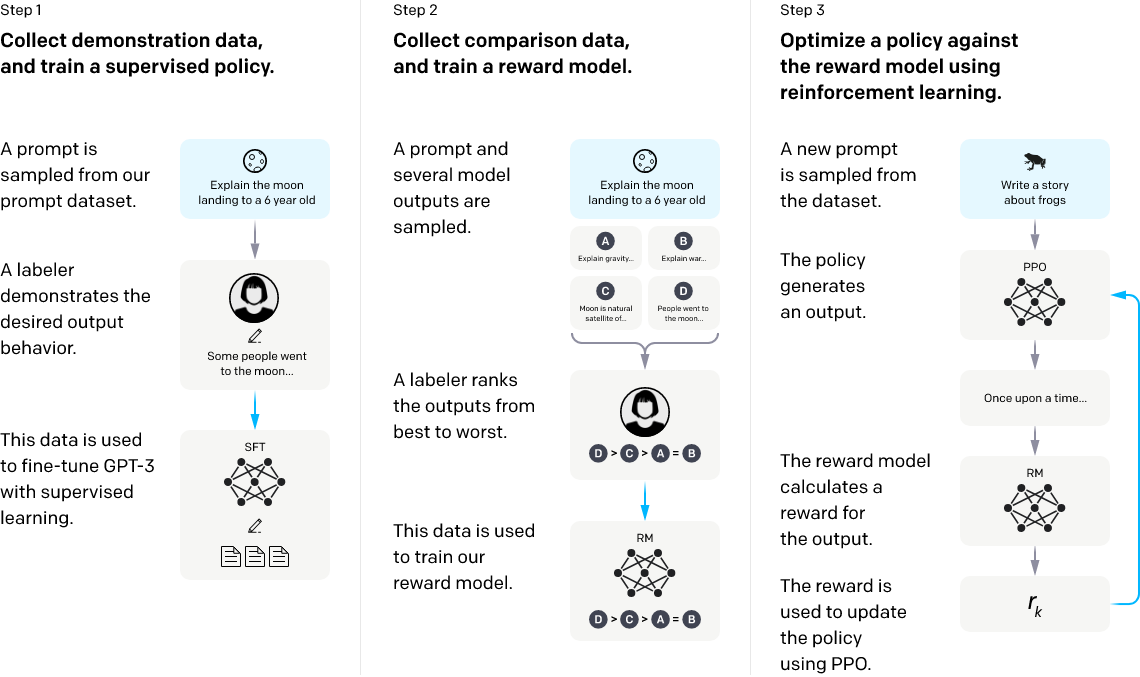

 При обучении ChatGPT также использовался метод обучения с подкреплением с обратной связью от человека. Отличия состоят в том, что ChatGPT была дообучена для задачи моделирования диалога.

## Классификация больших языковых моделей

Все существующие большие языковые модели можно разделить на три группы:
- <font color='F77FA2'> энкодерные</font>
- <font color='506ECC'>декодерные</font>
- <font color='67BF70'>энкодер-декодер</font>

<font color='A3A495'>Серым</font> обозначены модели, которые не имеют отношения к трансформерам.

Можно увидеть эволюцию по годам (снизу вверх). Цветом обозначены открытые модели, белым — доступные по подписке.

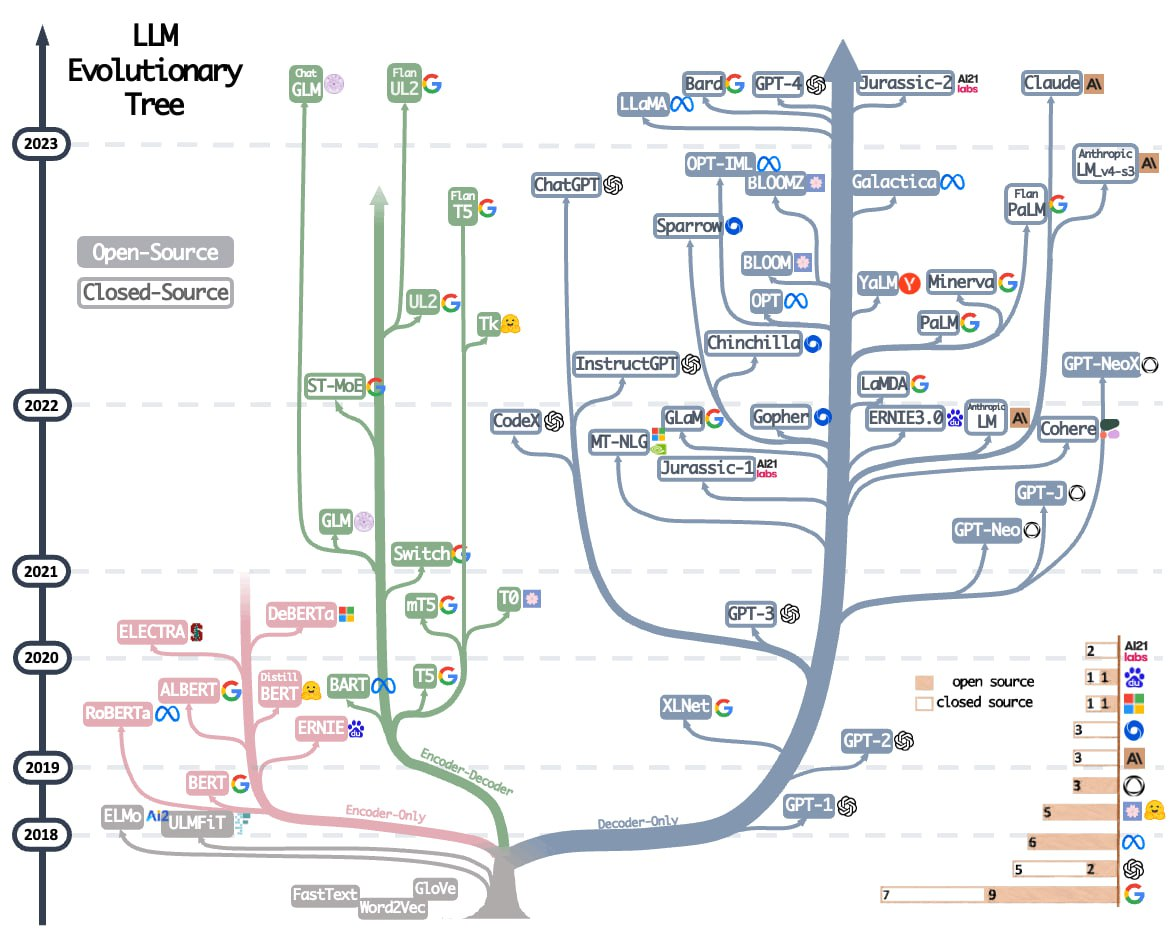

В начале развития больших языковых моделей были наиболее популярны энкодерные архитектуры, однако для их использования требуется дообучение на конкретной задаче. После появления GPT-3 интерес сместился в сторону декодерных моделей, поскольку их можно использовать для решения различных задач без дополнительного обучения.